![alt Text](Task4.JPG)

Полезные ссылки:

https://www.programcreek.com/python/example/88794/lightgbm.LGBMRegressor

https://colab.research.google.com/github/d2l-ai/d2l-en-colab/blob/master/chapter_multilayer-perceptrons/kaggle-house-price.ipynb#scrollTo=dq-DZf8hcNjW

https://www.kaggle.com/shreayan98c/boston-house-price-prediction

1) Засабмитить результат лучшего решения задачи
2) Попробовать регуляризацию(где я подписал)
3) Разобраться почему одна обработка хуже другой

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import lightgbm as lgb

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data transformer

In [2]:
class DataTransformer:
    def __init__(self, scaler=None):
        if scaler is not None:
            self.scaler = scaler
        else:
            self.scaler = StandardScaler()
        self.enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.imputer = IterativeImputer(max_iter=10, random_state=0) 
        

    def fit_encoder(self, X):
        o_cols = X.select_dtypes([object]).columns
        self.enc.fit(X[o_cols])


    def encode(self, X):
        # select object cols
        o_cols = X.select_dtypes([object]).columns
        # encode those and create df
        encoded = self.enc.transform(X[o_cols])  # one_hot_encode(X)
        df = pd.DataFrame(encoded)
        # drop object cols and append encoded
        result = X.drop(columns=o_cols)
        print(result.shape, df.shape)
        result = pd.concat([result.reset_index(drop=True), df.reset_index(drop=True)], axis=1)
        return result


    def imputer_fit(self, X):
        self.imputer.fit(X)


    def imputer_transform(self, X):
        return self.imputer.transform(X)


    def scaler_fit(self, X):
        self.scaler.fit(X)


    def scaler_transform(self, X):
        return self.scaler.transform(X)


    def nums_to_cats(self, X):
        num_to_cats = ["HalfBath", "KitchenAbvGr", "Fireplaces", "FullBath", "OverallCond", "OverallQual",
                       "TotRmsAbvGrd", "MSSubClass", "MoSold", "YrSold"]
        for feat in num_to_cats:
            X[feat] = X[feat].apply(str).astype("object")
        return X


    def fillna(self, X):
        # категории у которых остуствие значения означает == 0, 
        # так если машин в гараже None, то их наверно 0)
        zero_nan_cols = ['GarageArea', 'GarageCars', "MasVnrArea", 'BsmtFinSF1', 'BsmtFinSF2',
                         'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr',
                         "1stFlrSF", "2ndFlrSF"]
        for col in zero_nan_cols:
            X[col] = X[col].fillna(0)
        X['Functional'] = X['Functional'].fillna('Typ')  # Typical Functionality
        X['Electrical'] = X['Electrical'].fillna("SBrkr")  # Standard Circuit Breakers & Romex
        X['KitchenQual'] = X['KitchenQual'].fillna("TA")  # Typical/Average
        for col in X.columns:
            if X[col].dtype == "object":
                X[col] = X[col].fillna("None")
                X[col] = X[col].astype("object")


    def drop_columns(self, X):
        cats_to_drop = ["Utilities", "GarageYrBlt", "YearRemodAdd"]
        X = X.drop(cats_to_drop, axis=1)
        return X


    def prepare(self, X):
        X = self.drop_columns(X)
        self.nums_to_cats(X)
        self.fillna(X)
        return X


    def fit(self, X):
        num_candidates = list(X.dtypes[X.dtypes != "object"].index.values)
        self.imputer_fit(X[num_candidates])
        numeric = self.imputer_transform(X[num_candidates])
        self.scaler_fit(numeric)
        self.fit_encoder(X)


    def transform(self, X, encode = True):
        num_candidates = list(X.dtypes[X.dtypes != "object"].index.values)
        X[num_candidates] = self.imputer_transform(X[num_candidates])
        X[num_candidates] = self.scaler_transform(X[num_candidates])
        if encode:
            X = self.encode(X)
        return X

## Initialization

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data = train_data.drop(columns=["Id"])
val_ids = test_data["Id"]
test_data = test_data.drop(columns=["Id"])

## Playground

In [4]:
print(train_data.shape)
print(test_data.shape)

(1460, 80)
(1459, 79)


In [5]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass MSZoning  LotFrontage  LotArea SaleType SaleCondition  SalePrice
0          60       RL         65.0     8450       WD        Normal     208500
1          20       RL         80.0     9600       WD        Normal     181500
2          60       RL         68.0    11250       WD        Normal     223500
3          70       RL         60.0     9550       WD       Abnorml     140000


In [6]:
train_data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

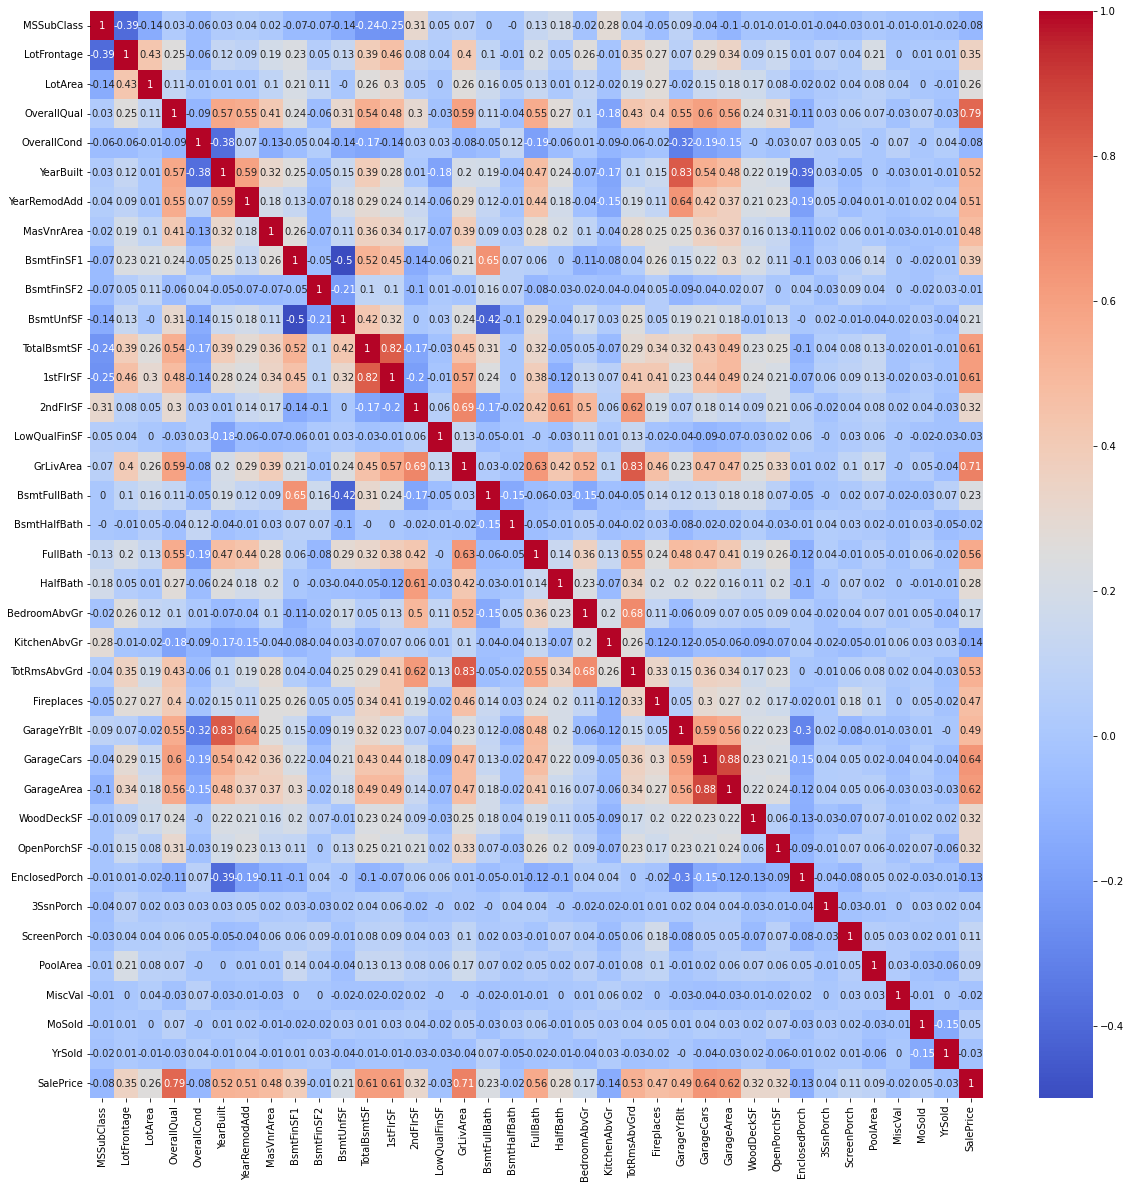

In [7]:
# Plot the correlation heatmap
plt.figure(figsize=(20, 20))
corr_matrix = train_data.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)

# Task

In [4]:
def remove_outliers(X):
    ids = X[((X['GrLivArea'] > 4000) & (X["SalePrice"] < 300000)) | (X["LotArea"] > 100000)].index

    return X.drop(ids)
train_data = remove_outliers(train_data)

In [5]:
# !!заменить на просто log
y = np.log1p(train_data["SalePrice"])
X = train_data.drop(columns=["SalePrice"])

print(X.shape)
X.head()

(1454, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [6]:
# По заданию сказали сид брать 98987, вот мы и берём такой сид 0_0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)

# Test

In [7]:
X_train_orig = X_train.copy()
transformer = DataTransformer(StandardScaler())
X_train = transformer.prepare(X_train)
X_test = transformer.prepare(X_test)
transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

(1163, 24) (1163, 338)
(291, 24) (291, 338)


In [8]:
print(X_train.isnull().sum().sum())
X_train.head()

0


,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,328,329,330,331,332,333,334,335,336,337
0,-0.949259,-0.736211,-1.489457,-0.565665,-1.012857,-0.285104,0.715367,-0.406139,-0.692505,-0.798547,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.360391,0.399284,0.996677,-0.565665,0.517566,-0.285104,-0.657973,-0.261436,-0.584126,1.259460,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.308758,-0.028030,-0.229816,0.398496,-0.562462,1.986686,0.921595,1.118067,0.965706,-0.798547,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.762863,-1.098791,-1.489457,-0.565665,0.062576,-0.285104,-0.494804,-0.565313,-0.925522,0.133987,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.497655,-0.352053,-0.561300,-0.565665,-1.012857,-0.285104,0.844543,-0.268671,-0.440522,0.287879,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
test_data = transformer.prepare(test_data)
test_data = transformer.transform(test_data)

(1459, 24) (1459, 338)


In [10]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def evaluate(model, X, y):
    preds = model.predict(X)
    print("RMSLE: " + str(rmsle(preds, y)))

# CatBoostRegressor 

In [18]:
# Initialize features
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]
# Initialize data
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)
# Initialize CatBoostRegressor
cat_model = CatBoostRegressor(iterations = 100000, task_type = "GPU",  devices = '0:1')
# Fit model
cat_model.fit(train_pool, eval_set = dev_pool, early_stopping_rounds = 10, verbose = 0, plot = False)

In [19]:
# Loss на трейне
evaluate(cat_model, X_train, y_train)
# Loss на трейне
evaluate(cat_model, X_test, y_test)

RMSLE: 0.09819099801814425
RMSLE: 0.12710494588806628


In [39]:
# Сохраняем результаты на тесте
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(cat_model.predict(test_data))})
df.to_csv('catBoost.csv', encoding='utf-8',index=False)

# LGBMRegressor

In [67]:
#data preparing
def lgbm_data_prepare(X):
    for c in X.columns:
        if X[c].dtype == 'object' or X[c].dtype.name == 'category':
            X[c] = X[c].astype('category')
# Подбираем параметры, анализирую параметры отсюда: https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm 
lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=128, learning_rate=0.005,
                        n_estimators=5000, max_bin=512, bagging_fraction=0.75, bagging_freq=5,
                        bagging_seed= 7, feature_fraction=0.2, feature_fraction_seed=7,
                        verbose=-1, max_depth=8)

fit_params = {"early_stopping_rounds": 1000,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1
              }
lgbm_model.fit(X_train, y_train, **fit_params)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7,
              learning_rate=0.005, max_bin=512, max_depth=8, n_estimators=5000,
              num_leaves=128, objective='regression', verbose=-1)

In [68]:
evaluate(lgbm_model, X_train, y_train)
evaluate(lgbm_model, X_test, y_test)

RMSLE: 0.05526670271666582
RMSLE: 0.11935012283949596


## Теперь не будем ничего придумывать и попытаемся найти наилучшие параметры для нашего LGRMRegressor

In [70]:

from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from hyperopt import fmin, tpe, hp, anneal, Trials

In [73]:
def searcher(params):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
              'bagging_freq': int(params['bagging_freq']),
              'max_bin': int(params['max_bin'])}
    clf = lgb.LGBMRegressor(random_state=42, **params)
    kf = KFold(n_splits = 4, shuffle = True)
    loss_list = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)
        prediction = clf_fold.predict(X_test_fold)
        loss = rmsle(prediction, y_test_fold)
        loss_list.append(loss)
    score = np.mean(loss_list)
    return score

In [74]:
# Задаём параметры, которые мы будем искать
space={'n_estimators': hp.quniform('n_estimators', 100, 10000, 10),
       'max_depth' : hp.quniform('max_depth', 2, 30, 1),
       'num_leaves' : hp.quniform('num_leaves', 2, 156, 2),
       'learning_rate': hp.loguniform('learning_rate', -5, 0),
       'bagging_freq':  hp.quniform('bagging_freq', 2, 20, 1),
       'max_bin':  hp.quniform('max_bin', 200, 540, 6),
       }
# Ищем лучшее решение с помощью вспомогательной функций
best=fmin(fn = searcher, # function to optimize
          space = space,
          algo = tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals = 100, # maximum number of iterations
          trials = Trials(), # logging
          rstate = np.random.default_rng(42) # fixing random state for the reproducibility
          )
# Выводим лучшее решение
print("Best parameters for LGBM is: {}".format(best))

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] baggi

In [87]:
lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=98, learning_rate=0.03464738630607564,
                        n_estimators=4430, max_bin=246, bagging_freq=10, max_depth=2)

fit_params = {"early_stopping_rounds": 1000,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1
              }
lgbm_model.fit(X_train, y_train, **fit_params)
evaluate(lgbm_model, X_train, y_train)
evaluate(lgbm_model, X_test, y_test)
evaluate(lgbm_model, X_test, y_test)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
RMSLE: 0.0862738905077867
RMSLE: 0.12030658523259863


# XGBRegressor

In [17]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=1.,
    eta=0.01,
    max_depth=2,
    min_child_weight=1.5,
    n_estimators=14000,
    alpha=0.,
    reg_lambda=0.4,
    subsample=0.2)
xgb_model.fit(X_train, y_train, verbose=False)

XGBRegressor(alpha=0.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             eta=0.01, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_delta_step=0, max_depth=2, min_child_weight=1.5, missing=nan,
             monotone_constraints='()', n_estimators=14000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.4, scale_pos_weight=1, subsample=0.2,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
print("RMSLE: " + str(rmsle(xgb_model.predict(X_train), y_train))) # overfitting?
print("RMSLE: " + str(rmsle(xgb_model.predict(X_test), y_test)))


RMSLE: 0.04000282843351767
RMSLE: 0.1131827529414371


# Делаем сабмишн

In [11]:
# Initialize features
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]
# Initialize data
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)
# Initialize CatBoostRegressor
cat_model = CatBoostRegressor(iterations = 100000, task_type = "GPU",  devices = '0:1')
# Fit model
cat_model.fit(train_pool, eval_set = dev_pool, early_stopping_rounds = 10, verbose = 0, plot = False)
# Loss на трейне
evaluate(cat_model, X_train, y_train)
# Loss на трейне
evaluate(cat_model, X_test, y_test)
# Сохраняем результаты на тесте
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(cat_model.predict(test_data))})
df.to_csv('catBoost.csv', encoding='utf-8',index=False)

RMSLE: 0.09819099801814425
RMSLE: 0.12710494588806628


In [16]:
lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=100, learning_rate=0.03464738630607564,
                        n_estimators=4430, max_bin=246, bagging_freq=10, max_depth=2)

fit_params = {"early_stopping_rounds": 1000,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1
              }
lgbm_model.fit(X_train, y_train, **fit_params)
evaluate(lgbm_model, X_train, y_train)
evaluate(lgbm_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(lgbm_model.predict(test_data))})
df.to_csv('lgbm.csv', encoding='utf-8',index=False)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
RMSLE: 0.0862738905077867
RMSLE: 0.12030658523259863


In [21]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=1.,
    eta=0.01,
    max_depth=2,
    min_child_weight=1.5,
    n_estimators=14000,
    alpha=0.,
    reg_lambda=0.4,
    subsample=0.2)
xgb_model.fit(X_train, y_train, verbose=False)
evaluate(xgb_model, X_train, y_train)
evaluate(xgb_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(xgb_model.predict(test_data))})
df.to_csv('xgb.csv', encoding='utf-8',index=False)

RMSLE: 0.04000282843351767
RMSLE: 0.1131827529414371


In [ ]:
lgbm_model = lgb.LGBMRegressor(objective='regression', 
num_leaves=   30, 
learning_rate=0.01204738630607564,
n_estimators= 3452, 
max_depth=    26, 
reg_alpha=    0.670024820643)

fit_params = {"early_stopping_rounds": 1000,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1
              }
lgbm_model.fit(X_train, y_train, **fit_params)
evaluate(lgbm_model, X_train, y_train)
evaluate(lgbm_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(lgbm_model.predict(test_data))})
df.to_csv('lgbm.csv', encoding='utf-8',index=False)

In [22]:
from hyperopt.pyll import scope
import lightgbm as lgb
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from hyperopt import fmin, tpe, hp, anneal, Trials

folds = 4
shuffle = True

random_state = 42

def objective(params):
    clf = lgb.LGBMRegressor(random_state=random_state,
                            **params)

    kf = KFold(n_splits=folds, shuffle=shuffle)
    loss_list = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        fit_params = {"early_stopping_rounds": 20,
                      "eval_metric": 'rmse',
                      "eval_set": [(X_test_fold, y_test_fold)],
                      'verbose': -1,
                      'categorical_feature': cat_features
                      }

        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)
        prediction = clf_fold.predict(X_test_fold)
        loss = rmsle(prediction, y_test_fold)
        loss_list.append(loss)
    score = np.mean(loss_list)
    return score

space = {'n_estimators': scope.int(hp.quniform('n_estimators', 100, 20000, 1)),
         'max_depth': scope.int(hp.quniform('max_depth', 2, 30, 1)),
         'num_leaves': scope.int(hp.quniform('num_leaves', 2, 40, 1)),
         'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
         'reg_lambda': hp.loguniform('reg_lambda', -5, 0),
         'learning_rate': hp.loguniform('learning_rate', -5, 0),
         'subsample': hp.loguniform('subsample', -5, 0),
         'colsample_bytree': hp.loguniform('colsample_bytree', -5, 0),
         }

trials = Trials()

best = fmin(fn=objective,  
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(random_state)
            )

print("best {}".format(best))

100%|██████████| 100/100 [02:17<00:00,  1.37s/trial, best loss: 0.1275144185428579]
best {'colsample_bytree': 0.12808309531576725, 'learning_rate': 0.028450064585128214, 'max_depth': 3.0, 'n_estimators': 15449.0, 'num_leaves': 22.0, 'reg_alpha': 0.13802235386130202, 'reg_lambda': 0.012750478433951934, 'subsample': 0.008033569475245078}


In [23]:
from hyperopt.pyll import scope
import lightgbm as lgb
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from hyperopt import fmin, tpe, hp, anneal, Trials

folds = 4
shuffle = True
random_state = 42

def objective(params):
    clf = lgb.LGBMRegressor(random_state=random_state,
                            **params)
    kf = KFold(n_splits=folds, shuffle=shuffle)
    loss_list = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        fit_params = {"early_stopping_rounds": 20,
                      "eval_metric": 'rmse',
                      "eval_set": [(X_test_fold, y_test_fold)],
                      'verbose': -1,
                      'categorical_feature': cat_features
                      }
        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)
        loss_list.append(rmsle(clf_fold.predict(X_test_fold), y_test_fold))
    score = np.mean(loss_list)
    return score


space = {'n_estimators': scope.int(hp.quniform('n_estimators', 100, 20000, 1)),
         'max_depth': scope.int(hp.quniform('max_depth', 2, 40, 1)),
         'num_leaves': scope.int(hp.quniform('num_leaves', 2, 130, 1)),
         'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
         'reg_lambda': hp.loguniform('reg_lambda', -5, 0),
         'learning_rate': hp.loguniform('learning_rate', -5, 0),
         'subsample': hp.loguniform('subsample', -5, 0),
         'colsample_bytree': hp.loguniform('colsample_bytree', -5, 0),
         }
trials = Trials()

best = fmin(fn=objective, 
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials, 
            rstate=np.random.default_rng(random_state) 
            )

print("best {}".format(best))

100%|██████████| 200/200 [05:10<00:00,  1.55s/trial, best loss: 0.12728985626936862]
best {'colsample_bytree': 0.14816321441420272, 'learning_rate': 0.03676604709218892, 'max_depth': 4.0, 'n_estimators': 14957.0, 'num_leaves': 107.0, 'reg_alpha': 0.015689501097174364, 'reg_lambda': 0.012134601260082634, 'subsample': 0.0322279320857844}


In [25]:
lgbm_model = lgb.LGBMRegressor(objective='regression', 
num_leaves=   107, 
learning_rate=0.03676604709218892,
n_estimators= 14957, 
max_depth=    4, 
reg_alpha=    0.015689501097174364,
reg_lambda=   0.012134601260082634,
subsample =   0.0322279320857844)

fit_params = {"early_stopping_rounds": 1000,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1
              }
lgbm_model.fit(X_train, y_train, **fit_params)
evaluate(lgbm_model, X_train, y_train)
evaluate(lgbm_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(lgbm_model.predict(test_data))})
df.to_csv('lgbm.csv', encoding='utf-8',index=False)

RMSLE: 0.06177261808340387
RMSLE: 0.126398806504664


In [41]:
def searcher(params):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'learning_rate': params['learning_rate'],
              'min_child_weight': params['min_child_weight'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'colsample_bytree': params['colsample_bytree'],
              'eta':params['eta'],
              }
    clf = xgb.XGBRegressor(random_state = 42, **params)
    kf = KFold(n_splits = 4, shuffle = True)
    loss_list = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, 
        early_stopping_rounds=20, 
        eval_set=[(X_test_fold, y_test_fold)], 
        verbose=False)
        loss_list.append(rmsle(clf_fold.predict(X_test_fold), y_test_fold))
    score = np.mean(loss_list)
    return score

par={'n_estimators': hp.quniform('n_estimators', 100, 10000, 10),
        'max_depth' : hp.quniform('max_depth', 2, 30, 1),
        'learning_rate': hp.loguniform('learning_rate', -5, 0),
        'eta': hp.loguniform('eta', -5, 0),
        'min_child_weight':  hp.quniform('min_child_weight', 0, 10, 0.01),
        'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
        'reg_lambda': hp.loguniform('reg_lambda', -5, 0),
        'colsample_bytree': hp.loguniform('colsample_bytree', -5, 0),
         'subsample': hp.loguniform('subsample', -5, 0),
       }
       
best=fmin(fn = searcher, 
          space = par,
          algo = tpe.suggest, 
          max_evals = 50, 
          trials = Trials(), 
          rstate = np.random.default_rng(42) 
          )
print("Best parameters for xgb is: {}".format(best))

100%|██████████| 50/50 [06:15<00:00,  7.51s/trial, best loss: 0.1232732063383142] 
Best parameters for xgb is: {'colsample_bytree': 0.099799911416915, 'eta': 0.012320740203440417, 'learning_rate': 0.022866232035316632, 'max_depth': 4.0, 'min_child_weight': 7.46, 'n_estimators': 5180.0, 'reg_alpha': 0.04682186658186055, 'reg_lambda': 0.787023341549662}


In [44]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=best['colsample_bytree'],#
    eta=best['eta'], #
    max_depth=int(best['max_depth']),#
    min_child_weight=best['min_child_weight'],#
    n_estimators=int(best['n_estimators']),#
    reg_alpha = best['reg_alpha'],#
    reg_lambda=best['reg_lambda'],#
    learning_rate = best['learning_rate'], #
    )
xgb_model.fit(X_train, y_train, verbose=False)
evaluate(xgb_model, X_train, y_train)
evaluate(xgb_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(xgb_model.predict(test_data))})
df.to_csv('xgb.csv', encoding='utf-8',index=False)

RMSLE: 0.017570084107965594
RMSLE: 0.11821680614586876


In [45]:
def searcher(params):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'learning_rate': params['learning_rate'],
              'min_child_weight': params['min_child_weight'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'colsample_bytree': params['colsample_bytree'],
              'eta':params['eta'],
              }
    clf = xgb.XGBRegressor(random_state = 42, **params)
    kf = KFold(n_splits = 4, shuffle = True)
    loss_list = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, 
        early_stopping_rounds=20, 
        eval_set=[(X_test_fold, y_test_fold)], 
        verbose=False)
        loss_list.append(rmsle(clf_fold.predict(X_test_fold), y_test_fold))
    score = np.mean(loss_list)
    return score

par={'n_estimators': hp.quniform('n_estimators', 100, 10000, 10),
        'max_depth' : hp.quniform('max_depth', 2, 30, 1),
        'learning_rate': hp.loguniform('learning_rate', -5, 0),
        'eta': hp.loguniform('eta', -5, 0),
        'min_child_weight':  hp.quniform('min_child_weight', 0, 10, 0.01),
        'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
        'reg_lambda': hp.loguniform('reg_lambda', -5, 0),
        'colsample_bytree': hp.loguniform('colsample_bytree', -5, 0),
         'subsample': hp.loguniform('subsample', -5, 0),
       }
       
best=fmin(fn = searcher, 
          space = par,
          algo = tpe.suggest, 
          max_evals = 100, 
          trials = Trials(), 
          rstate = np.random.default_rng(42) 
          )
print("Best parameters for xgb is: {}".format(best))

100%|██████████| 100/100 [08:36<00:00,  5.16s/trial, best loss: 0.12187038234637534]
Best parameters for xgb is: {'colsample_bytree': 0.15299258531032164, 'eta': 0.0122631550112126, 'learning_rate': 0.015638047232613618, 'max_depth': 9.0, 'min_child_weight': 1.8, 'n_estimators': 4130.0, 'reg_alpha': 0.12415857486051943, 'reg_lambda': 0.02045999680667947, 'subsample': 0.3048387732285504}


In [48]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=best['colsample_bytree'],#
    eta=best['eta'], #
    max_depth=int(5),#
    min_child_weight=best['min_child_weight'],#
    n_estimators=int(best['n_estimators']),#
    reg_alpha = best['reg_alpha'],#
    reg_lambda=best['reg_lambda'],#
    learning_rate = best['learning_rate'], #
    )
xgb_model.fit(X_train, y_train, verbose=False)
evaluate(xgb_model, X_train, y_train)
evaluate(xgb_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(xgb_model.predict(test_data))})
df.to_csv('xgb.csv', encoding='utf-8',index=False)

RMSLE: 0.01786469976818271
RMSLE: 0.11252963747747277


In [51]:
def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')

In [52]:
to_categorical(X_train)
to_categorical(X_test)

cat_features = list(X_train.select_dtypes(include=['category']).columns)

In [54]:
from hyperopt.pyll import scope
import lightgbm as lgb
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from hyperopt import fmin, tpe, hp, anneal, Trials
folds = 4
shuffle = True
random_state = 42

def objective(params):
    clf = lgb.LGBMRegressor(random_state=random_state,
                            **params)
    kf = KFold(n_splits=folds, shuffle=shuffle)
    loss_list = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        fit_params = {"early_stopping_rounds": 20,
                      "eval_metric": 'rmse',
                      "eval_set": [(X_test_fold, y_test_fold)],
                      'verbose': -1,
                      'categorical_feature': cat_features
                      }
        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)
        loss_list.append(rmsle(clf_fold.predict(X_test_fold), y_test_fold))

    score = np.mean(loss_list)
    return score


space = {'n_estimators': scope.int(hp.quniform('n_estimators', 100, 20000, 1)),
         'max_depth': scope.int(hp.quniform('max_depth', 2, 40, 1)),
         'num_leaves': scope.int(hp.quniform('num_leaves', 2, 130, 1)),
         'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
         'reg_lambda': hp.loguniform('reg_lambda', -5, 0),
         'learning_rate': hp.loguniform('learning_rate', -5, 0),
         'subsample': hp.loguniform('subsample', -5, 0),
         'colsample_bytree': hp.loguniform('colsample_bytree', -5, 0),
         }
trials = Trials()

best = fmin(fn=objective, 
            space=space,
            algo=tpe.suggest, 
            max_evals=200, 
            trials=trials,  
            rstate=np.random.default_rng(random_state)  
            )

print("best {}".format(best))

100%|██████████| 200/200 [05:22<00:00,  1.61s/trial, best loss: 0.12543210129405835]
best {'colsample_bytree': 0.16783982495314342, 'learning_rate': 0.0154761578469205, 'max_depth': 14.0, 'n_estimators': 19099.0, 'num_leaves': 8.0, 'reg_alpha': 0.35520647897604624, 'reg_lambda': 0.008794296313234013, 'subsample': 0.9305133417305286}


In [55]:
lgbm_model = lgb.LGBMRegressor(objective='regression', 
num_leaves=   8, 
learning_rate=0.0154761578469205,
n_estimators= 19099, 
max_depth=    14, 
reg_alpha=    0.35520647897604624,
reg_lambda=   0.008794296313234013,
subsample =   0.9305133417305286,
colsample_bytree = 0.16783982495314342)

fit_params = {"early_stopping_rounds": 1000,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1
              }
lgbm_model.fit(X_train, y_train, **fit_params)
evaluate(lgbm_model, X_train, y_train)
evaluate(lgbm_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(lgbm_model.predict(test_data))})
df.to_csv('lgbm.csv', encoding='utf-8',index=False)

RMSLE: 0.07877139621546816
RMSLE: 0.12178829802344258


In [56]:
# Initialize data
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)
# Initialize CatBoostRegressor
cat_model=CatBoostRegressor(iterations=100000, task_type = "GPU",  devices = '0:1', learning_rate=0.05,  loss_function='RMSE', logging_level='Silent')
cat_model.fit(train_pool,eval_set=dev_pool, early_stopping_rounds = 10, verbose = 0, plot = False)
# Loss на трейне
evaluate(cat_model, X_train, y_train)
# Loss на трейне
evaluate(cat_model, X_test, y_test)
# Сохраняем результаты на тесте
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(cat_model.predict(test_data))})
df.to_csv('cat.csv', encoding='utf-8',index=False)

RMSLE: 0.09688273542226804
RMSLE: 0.12659722038821397


![alt Text](Untitled.png)

{'colsample_bytree': 0.18246223812848744, 'eta': 0.34447760663533794, 'gamma': 0.015971546931669918, 'learning_rate': 0.017440011926925455, 'max_depth': 3.0, 'min_child_weight': 0.47000000000000003, 'n_estimators': 15340.0, 'reg_alpha': 0.06743237729410853, 'reg_lambda': 0.02285593844088651, 'subsample': 0.1645130686623509}

In [62]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree=0.18246223812848744,#
    eta=0.34447760663533794, #
    max_depth=3,#
    min_child_weight=0.47000000000000003,#
    n_estimators=15340,#
    reg_alpha = 0.06743237729410853,#
    reg_lambda=0.02285593844088651,#
    learning_rate = 0.017440011926925455, #
    gamma= 0.015971546931669918,
    subsample =0.1645130686623509
    )
xgb_model.fit(X_train, y_train, verbose=False)
evaluate(xgb_model, X_train, y_train)
evaluate(xgb_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(xgb_model.predict(test_data))})
df.to_csv('xgb.csv', encoding='utf-8',index=False)

RMSLE: 0.0466397123194967
RMSLE: 0.11338021039389141


best {'bagging_freq': 2.0, 'colsample_bytree': 0.15097225953039, 'learning_rate': 0.010293384110609679, 'max_bin': 90.0, 'max_depth': 40.0, 'n_estimators': 18470.0, 'num_leaves': 51.0, 'reg_alpha': 0.16007562982758342, 'reg_lambda': 0.06230070029719027, 'subsample': 0.99793362952176}

In [63]:
lgbm_model = lgb.LGBMRegressor(objective='regression', 
bagging_freq=   2, 
colsample_bytree=0.15097225953039,
learning_rate= 0.010293384110609679, 
max_bin=    90, 
max_depth=    40,
n_estimators=   18470,
num_leaves =   51,
reg_alpha = 0.16007562982758342,
reg_lambda = 0.06230070029719027, 
subsample = 0.99793362952176)

fit_params = {"early_stopping_rounds": 1000,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1
              }
lgbm_model.fit(X_train, y_train, **fit_params)
evaluate(lgbm_model, X_train, y_train)
evaluate(lgbm_model, X_test, y_test)
df = pd.DataFrame({'Id':val_ids.values,
                'SalePrice':np.expm1(lgbm_model.predict(test_data))})
df.to_csv('lgbm.csv', encoding='utf-8',index=False)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
RMSLE: 0.05790237669892909
RMSLE: 0.12241500473813523


# CatBoost

*Online learning - вычисляет статистики по мере поступления

кэт считает статистику по тем объектам, на которых он ещё не обучался, это типо online learning
у котов это немного сложнее сделано, у них это назвали ordered boosting
## OrderedBoosting 

помогает бороться с переобучением:

строить оценки для каждого след объекта на алгоритме, который построен на предыдущих моделях. Получаем несмещенную оценку, тк она не обучалась на этом объекте.
	
## Статистика по целевому признаку:

	Считаем среднее:

Взяли все объекты, у которых значение признака совпадает со значением признака на объекте X, и по ним усреднили ‘y’

![form 1](Formula1.JPG)

Чтобы не переобучиться идём по перестановкам подвыборок

![form 1](Formula2.JPG)

![form 1](Formula3.JPG)

r-я перестановка, j по степеням двойки. i-го объекта в выборке нема, оценка несмещённая

OrderedTS - вычисляет статистику по мере прохода по данным используя только те сэмлы, что были перед ним

На лету образуются сочетания кат. признаков, во избежание комбинаторного взрыва сочетания строятся на лету. 

На каждом новом сплите, метод комбинирует (конкатенирует) все кат. фичи (их их комбинации) использовавшиеся на прошлых сплитах со остальными в датасете. Всё это преобразуется в TS на лету.


Небрежные решающие деревья (oblivios tree) - решающие таблицы. На каждом уровне во всех вершинах стоит один и тот же признак и одно и то же условие


Может в категориальные фичи “из коробки”

Быстро учится

есть GPU версия

Утверждают, что хорошо работает с дефолтными параметрами, т.к. качество не сильно скачет от изменения параметров

Может комбинировать разные категориальные факторы друг с другом

ещё раз - более хитрая обработка категориальных признаков, комбинации признаков, отличается схема вычислений значений в листьях

Говорят, только для float32 нет копирования

![form 1](Formula4.JPG)
Ordered boosting:

Оценка градиента не по всем объектам, которые попали в лист, а по тем которые были раньше


Ссылки:

https://arxiv.org/abs/1706.09516

https://youtu.be/KRURAkRMo4k?t=3521